In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

2023-12-25 12:19:39.352240: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-25 12:19:39.380217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 12:19:39.380251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 12:19:39.381120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 12:19:39.386412: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

In [5]:
# get all labels in the dataframes
keys_list = list(split_dataframes.keys())
random.Random(69).shuffle(keys_list) # shuffle, but with a seed for reproducability
split_idx = int(len(keys_list) * 0.8)
train_keys = keys_list[:split_idx]
train_labels_EW = []
train_labels_NS = []
val_keys = keys_list[split_idx:]
val_labels_EW = []
val_labels_NS = []
for key in train_keys:
    train_labels_EW += list(split_dataframes[key]['EW'].unique())
    train_labels_NS += list(split_dataframes[key]['NS'].unique())
for key in val_keys:
    val_labels_EW += list(split_dataframes[key]['EW'].unique())
    val_labels_NS += list(split_dataframes[key]['NS'].unique())
train_labels_EW = list(dict.fromkeys(train_labels_EW))
train_labels_NS = list(dict.fromkeys(train_labels_NS))
val_labels_EW = list(dict.fromkeys(val_labels_EW))
val_labels_NS = list(dict.fromkeys(val_labels_NS))
print(train_labels_EW)
print(val_labels_EW)
print(train_labels_NS)
print(val_labels_NS)


['SS-CK', 'SS-NK', 'AD-NK', 'IK-CK', 'SS-HK', 'ID-NK', 'SS-EK', 'IK-HK', 'IK-EK']
['SS-HK', 'ID-NK', 'SS-CK', 'SS-NK', 'AD-NK', 'IK-CK', 'IK-HK', 'SS-EK']
['SS-CK', 'SS-NK', 'IK-CK', 'SS-HK', 'ID-NK', 'IK-EK', 'IK-HK', 'SS-EK']
['SS-HK', 'ID-NK', 'SS-CK', 'SS-NK', 'IK-CK', 'IK-HK', 'SS-EK']


In [6]:
some_dataframes = {}
for df_k in ['121', '108', '124']:#list(split_dataframes.keys())[:3]:
    some_dataframes[df_k] = split_dataframes[df_k]

In [7]:
ds_gen = datahandler.DatasetGenerator(split_df=some_dataframes, input_features=input_features,
                                      train_val_split=0.85, stride=1,
                                      input_history_steps=8, input_future_steps=8, seed=69)

Creating dataset from 2 train and 1 val objects
Creating datasets with labels ['EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']


2023-12-25 12:19:45.284808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 12:19:45.314960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 12:19:45.315132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Created datasets with seed 69


In [8]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['EW', 'NS'], shuffle=True)
print(train_combined.element_spec)


2023-12-25 12:19:46.578940: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(TensorSpec(shape=(None, 16, 15), dtype=tf.float64, name=None), {'EW': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 16, 15)]             0         []                            
                                                                                                  
 flatten_4 (Flatten)         (None, 240)                  0         ['Input[0][0]']               
                                                                                                  
 dense_12 (Dense)            (None, 256)                  61696     ['flatten_4[0][0]']           
                                                                                                  
 dense_13 (Dense)            (None, 128)                  32896     ['dense_12[0][0]']            
                                                                                            

[0.435072660446167,
 0.018757283687591553,
 0.4163154363632202,
 0.9935543537139893,
 0.9309391975402832]

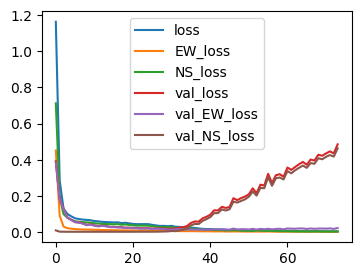

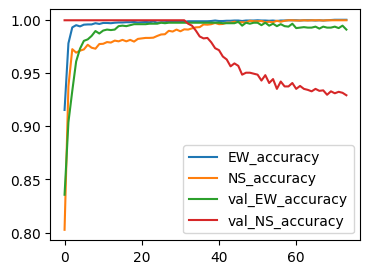

In [13]:
#dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_combined_model = prediction_models.CNN(train_combined, conv_layers=[128,128,128], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[20000,0.8], seed=0)

dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='EW_accuracy', epochs=75, verbose=1, plot_hist=False, callbacks=[], save_best_only=True)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])
dense_combined_model.evaluate(train_combined)
dense_combined_model.evaluate(val_combined)

In [ ]:
# TODO: find out if we can directly train for precision/challenge metrics
# TODO: maybe it makes sense to look at values before and after the node? Given that we are trying to detect changes...
# TODO: check if train_NS even contains all the labels in val_NS... in general, train should contain all labels
# TODO: Make sure labelencoder gets saved
# TODO: some of the features cross sign boundaries -> feature engineering necessary!?
# TODO: there is some kind of bug in the prediction_models where callbacks get maintained even when changed

In [14]:
def prepare_submission_df(ds, model, model_output_features, label_decoders, smoothing=False, smoothing_past_steps=3, smoothing_fut_steps=10):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element[feature] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    if smoothing:
        df = utils.smooth_predictions(df, past_steps=smoothing_past_steps, fut_steps=smoothing_fut_steps)
    return df


In [32]:
def evaluate_submission_df(prepared_df, ground_truth):
    results = utils.convert_classifier_output(prepared_df).sort_values(['ObjectID']).reset_index(drop=True)
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth, results)
    precision, recall, f2, rmse = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.2f}')

In [35]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)

In [36]:
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                               label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=3, smoothing_fut_steps=10)
evaluate_submission_df(df_train, ground_truth_train)


# Dense result: F2 0.49/0.32 (t/v)
# Dense result(w/ future): F2 0.46/0.45 (t/v) (256/128/54)

# Conv result (no future): F2 0.53/0.37
# Conv result (w/ future): F2 0.51/0.38

136/136 [==============================] - 0s 661us/step


Smoothing: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

Precision: 1.00
Recall: 0.67
F2: 0.71
RMSE: 3.10


In [37]:
train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                                label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=3, smoothing_fut_steps=10)
evaluate_submission_df(df_val, ground_truth_val)


68/68 [==============================] - 0s 828us/step


Smoothing: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Precision: 0.20
Recall: 0.40
F2: 0.33
RMSE: 4.24
